In [1]:
!nvidia-smi

Thu Jun  3 16:22:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!pip install allennlp-models
!pip install allennlp

     |████████████████████████████████| 430kB 8.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 634kB 41.1MB/s 
     |████████████████████████████████| 1.8MB 41.0MB/s 
     |████████████████████████████████| 133kB 56.3MB/s 
     |████████████████████████████████| 266kB 38.9MB/s 
     |████████████████████████████████| 122kB 51.7MB/s 
     |████████████████████████████████| 1.2MB 50.8MB/s 
     |████████████████████████████████| 2.1MB 48.4MB/s 
     |████████████████████████████████| 133kB 55.1MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 174kB 32.0MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
     |████████████████████████████████| 7.6MB 48.2MB/s 
     |████████████████████████████████| 901kB 40.2MB/s 
     |████████████████████████████████| 3.3MB 41.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s

In [4]:
from typing import Dict, Iterable, List

import torch
import pandas as pd
from allennlp.data import DatasetReader, Instance, Vocabulary, TextFieldTensors
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer, TokenCharactersIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer, CharacterTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding, TokenCharactersEncoder
from allennlp.modules.seq2vec_encoders import LstmSeq2VecEncoder, CnnEncoder
from allennlp.nn import util
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.data.data_loaders import MultiProcessDataLoader, DataLoader


In [5]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from typing import Dict
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt


def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True,
        save_dir='results'):
    """
        Vẽ confusion matrix
    """
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    width = int(10/7*len(target_names))

    height = int(8/7*len(target_names))

    # plt.figure(figsize=(width, height))
    plt.imshow(cm, cmap=cmap)
    # plt.title(title)
    plt.colorbar()

    if target_names:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    if os.path.exists(save_dir) is False:
        os.mkdir(save_dir)

    try:
        print(f"Save confusion-matrix...")
        plt.savefig((save_dir + '/{}.png'.format(title)))
    except IOError:
        print(f"Could not save file in directory: {save_dir}")

    plt.show()

In [6]:
def predict(model, text: str, max_tokens, token_indexers):
    tokens = [Token(token) for token in text.split(' ')]
    
    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]

    text_field = TextField(tokens, token_indexers)
    instance = Instance({
        "tokens": text_field
    })
    output = model.forward_on_instance(instance)
    y_prediction = np.argmax(output['probs'], axis=-1)
    y_probs = np.max(output['probs'], axis=-1)
    prediction = model.vocab.get_token_from_index(y_prediction, namespace='labels')
    return prediction

In [7]:
def predict_on_df(model, data_reader, data_df, label_col='sentiment'):
    vocab = model.vocab
    max_tokens = data_reader.max_tokens
    token_indexers = data_reader.token_indexers
    texts = data_df['text'].tolist()
    label_pred = [predict(model, text, max_tokens, token_indexers) for text in texts]
    data_df[f'{label_col}_pred'] = label_pred
    return data_df

In [8]:
def eval_model(model, data_reader, test_df, label_col='sentiment', plot_cm=False, average='macro'):
    vocab = model.vocab
    max_tokens = data_reader.max_tokens
    token_indexers = data_reader.token_indexers
    test_df = pd.read_csv(test_path)
    texts = test_df['text'].tolist()
    label_true = test_df[label_col].tolist()
    label_pred = [predict(model, text, max_tokens, token_indexers) for text in texts]
    y_true = [vocab.get_token_index(label, namespace='labels') for label in label_true]
    y_pred = [vocab.get_token_index(label, namespace='labels') for label in label_pred]

    # get metric scores
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    f1 = f1_score(y_true, y_pred, average=average)
    labels = list(vocab.get_token_to_index_vocabulary('labels').keys())
    report = classification_report(label_true, label_pred, labels=labels)
    print(f'Evaluate ')
    print('Accuracy :', acc)
    print('Precision:', precision)
    print('Recall   :', recall)
    print('F1-Score :', f1)
    print('Detail:')
    print(report)
    if plot_cm:
        cm = confusion_matrix(label_true, label_pred, labels=labels)
        plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix (sentiment)', normalize=False)
        plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix Normalize (sentiment)', normalize=True)
    return acc, precision, recall, f1

In [9]:
class SentimentDataReader(DatasetReader):
    def __init__(
        self,
        tokenizer: Tokenizer = None,
        char_tokenizer: CharacterTokenizer = None,
        token_indexers: Dict[str, TokenIndexer] = None,
        use_character: bool = True,
        max_tokens: int = None,
        label_col: str = 'sentiment',
        **kwargs
    ):
        super().__init__(**kwargs)
        self.tokenizer = tokenizer or WhitespaceTokenizer()
        self.char_tokenizer = char_tokenizer or CharacterTokenizer()
        if token_indexers is None:
            if use_character:
                self.token_indexers = {
                        "tokens": SingleIdTokenIndexer(namespace="tokens"),
                        "token_characters": TokenCharactersIndexer(namespace="token_characters", min_padding_length=3)
                    }
            else:
                self.token_indexers = {
                        "tokens": SingleIdTokenIndexer(namespace="tokens") 
                         }
        else:
            self.token_indexers = token_indexers
        self.max_tokens = max_tokens
        self.label_col = label_col

    def text_to_instance(self, text, label=None):
        tokens = self.tokenizer.tokenize(text)
        if self.max_tokens:
                tokens = tokens[: self.max_tokens]

        text_field = TextField(tokens, self.token_indexers)
        fields = {
            "tokens": text_field
        }
        if label:
            fields['label'] = LabelField(label)
        return Instance(fields)

    def _read(self, file_path) -> Iterable[Instance]:
        if isinstance(file_path, str):
            df = pd.read_csv(file_path)
        elif isinstance(file_path, pd.DataFrame):
            df = file_path
        for _, row in df.iterrows():
            text = row['text']
            sentiment = row[self.label_col]
            yield self.text_to_instance(text, sentiment)


In [10]:
from allennlp.training.metrics import CategoricalAccuracy, F1Measure

class SimpleClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2VecEncoder):
        super().__init__(vocab)
        self.embedder = embedder
        self.encoder = encoder
        num_labels = vocab.get_vocab_size("labels")
        self.classifier = torch.nn.Linear(encoder.get_output_dim(), num_labels)
        self.accuracy = CategoricalAccuracy()
        self.f1_measure = F1Measure(1)

    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(tokens)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(tokens)
        # Shape: (batch_size, encoding_dim)
        encoded_text = self.encoder(embedded_text, mask)
        # Shape: (batch_size, num_labels)
        logits = self.classifier(encoded_text)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits)
        # Shape: (1,)
        output = {
            'probs': probs,
            'logits': logits
        }
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            output['loss'] = loss
            self.accuracy(logits, label)
            self.f1_measure(logits, label)

        return output
    
    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics_result = self.f1_measure.get_metric(reset)
        metrics_result['accuracy'] = self.accuracy.get_metric(reset)
        
        return metrics_result

In [11]:
from allennlp.training.metrics import CategoricalAccuracy, F1Measure
from allennlp.modules.attention.attention import Attention
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder, Seq2SeqEncoder
from allennlp.modules.attention.linear_attention import LinearAttention
from allennlp.modules.attention.dot_product_attention import DotProductAttention
from allennlp.modules.attention.bilinear_attention import BilinearAttention
from allennlp.modules.attention.additive_attention import AdditiveAttention


class AttentionClassifier(Model):
    def __init__(self,
                 vocab: Vocabulary,
                 embedder: TextFieldEmbedder,
                 encoder: Seq2SeqEncoder,
                 dropout=0.4):
        super().__init__(vocab)
        self.embedder = embedder
        self.encoder = encoder
        self.bidirectional = self.encoder.is_bidirectional()
        if self.bidirectional:
            self.hidden_size = int(self.encoder.get_output_dim()/2)
        else:
            self.hidden_size = self.encoder.get_output_dim()
        self.num_labels = vocab.get_vocab_size("labels")
        self.attention_layer = AdditiveAttention(vector_dim=encoder.get_output_dim(), 
                                                 matrix_dim=encoder.get_output_dim(),
                                                 normalize=True)
        self.relu = torch.nn.ReLU()
        self.drop = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(self.encoder.get_output_dim()*2, self.num_labels)
        self.accuracy = CategoricalAccuracy()
        
        self.init_weight()
        
        self.f1_measure = F1Measure(1)
    
    def init_weight(self):
        # torch.nn.init.xavier_normal_(self.project_layer.weight)
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self,
                tokens: Dict[str, torch.Tensor],
                label: torch.Tensor = None) -> Dict[str, torch.Tensor]:
        # Shape: (batch_size, num_tokens, embedding_dim)
        embedded_text = self.embedder(tokens)
        # Shape: (batch_size, num_tokens)
        mask = util.get_text_field_mask(tokens)

        # Shape: (batch_size, encoding_dim) if use seq2vec
        # Shape: (batch_size, seq_len, encoding_dim) if use seq2seq
        encoded_text = self.encoder(embedded_text, mask)
        if self.bidirectional:
            last_forward = encoded_text[:, -1, :self.hidden_size]
            first_backward = encoded_text[:, 0, self.hidden_size:]
            context_vector = torch.cat([last_forward, first_backward], dim=-1)
        else:
            context_vector = encoded_text[:, -1, :]
        
        # Shape: (batch_size, seq_len)
        att_weight = self.attention_layer(context_vector, encoded_text)

        # Shape: (batch_size, hidden_size)
        att_hidden = torch.bmm(encoded_text.transpose(-2, -1), att_weight.unsqueeze(-1)).squeeze(-1)
        context_att = torch.cat([context_vector, att_hidden], dim=-1)
        # context_att = self.drop(att_hidden)
        logits = self.classifier(context_att)
        # Shape: (batch_size, num_labels)
        probs = torch.nn.functional.softmax(logits)
        # Shape: (1,)
        output = {
            'probs': probs,
            'logits': logits
        }
        if label is not None:
            loss = torch.nn.functional.cross_entropy(logits, label)
            output['loss'] = loss
            self.accuracy(logits, label)
            self.f1_measure(logits, label)

        return output
    
    def get_metrics(self, reset: bool = False) -> Dict[str, float]:
        metrics_result = self.f1_measure.get_metric(reset)
        metrics_result['accuracy'] = self.accuracy.get_metric(reset)
        
        return metrics_result

In [12]:
import tempfile
from typing import Dict, Iterable, List, Tuple
import shutil
import os

import allennlp
import torch
from allennlp.data import (
    DataLoader,
    DatasetReader,
    Instance,
    Vocabulary,
    TextFieldTensors,
)
from allennlp.data.data_loaders import SimpleDataLoader
from allennlp.data.fields import LabelField, TextField
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token, Tokenizer, WhitespaceTokenizer
from allennlp.models import Model
from allennlp.modules import TextFieldEmbedder, Seq2VecEncoder
from allennlp.modules.seq2vec_encoders import BagOfEmbeddingsEncoder
from allennlp.modules.token_embedders import Embedding
from allennlp.modules.text_field_embedders import BasicTextFieldEmbedder
from allennlp.nn import util
from allennlp.training.trainer import GradientDescentTrainer, Trainer
from allennlp.training.optimizers import AdamOptimizer
from allennlp.training.metrics import CategoricalAccuracy
from allennlp.modules.seq2seq_encoders import LstmSeq2SeqEncoder


train_path = '/content/drive/MyDrive/Learning/20202/NLP/data/train.csv'
test_path = '/content/drive/MyDrive/Learning/20202/NLP/data/test.csv'
val_path = '/content/drive/MyDrive/Learning/20202/NLP/data/val.csv'

def build_model(
    vocab,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    use_character=True,
    word_embedding_pretrain_file=None,
    use_attention=False
):
     # token embedding
    embedding = Embedding(embedding_dim=embedding_dim, vocab_namespace='tokens', vocab=vocab, pretrained_file=word_embedding_pretrain_file)
        
    # char embedding with cnnencoder
    character_embedding = Embedding(embedding_dim=char_embedding_dim, vocab_namespace='token_characters', vocab=vocab)
    cnn_encoder = CnnEncoder(embedding_dim=char_embedding_dim, num_filters=char_embedding_dim, ngram_filter_sizes=(3,))
    token_encoder = TokenCharactersEncoder(character_embedding, cnn_encoder)

    if use_character:
        embedder = BasicTextFieldEmbedder(
            {
                "tokens": embedding,
                "token_characters": token_encoder
            }
        )
    else:
        embedder = BasicTextFieldEmbedder(
            {
                "tokens": embedding            
             }
        )
    if use_attention:
            encoder = LstmSeq2SeqEncoder(input_size=embedder.get_output_dim(), hidden_size=hidden_size, num_layers=2, bidirectional=bidirectional, dropout=dropout)
    else:
        encoder = LstmSeq2VecEncoder(input_size=embedder.get_output_dim(), hidden_size=hidden_size, num_layers=2, bidirectional=bidirectional, dropout=dropout)
    if use_attention:
        model = AttentionClassifier(
            vocab,
            embedder,
            encoder,
            dropout=dropout
        )
    else:
        model = SimpleClassifier(
            vocab,
            embedder,
            encoder,
            
        )
    
    model.to('cuda')
    return model

def build_dataset_reader(max_tokens=80, label_col='sentiment', use_character=True) -> DatasetReader:
    return SentimentDataReader(max_tokens=max_tokens, label_col=label_col, use_character=use_character)


def read_data(reader: DatasetReader, train_path, val_path) -> Tuple[List[Instance], List[Instance]]:
    print("Reading data")
    training_data = list(reader.read(train_path))
    validation_data = list(reader.read(val_path))
    return training_data, validation_data


def build_vocab(instances: Iterable[Instance]) -> Vocabulary:
    print("Building the vocabulary")
    return Vocabulary.from_instances(instances)

def build_data_loaders(
    train_data: List[Instance],
    dev_data: List[Instance],
    batch_size=64
) -> Tuple[DataLoader, DataLoader]:
    train_loader = SimpleDataLoader(train_data, batch_size, shuffle=True)
    dev_loader = SimpleDataLoader(dev_data, batch_size, shuffle=False)
    return train_loader, dev_loader

def build_trainer(
    model,
    serialization_dir,
    train_loader,
    dev_loader,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001
):
    parameters = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
    optimizer = AdamOptimizer(parameters, lr=0.001, weight_decay=weight_decay)  # type: ignore
    trainer = GradientDescentTrainer(
        model=model,
        serialization_dir=serialization_dir,
        data_loader=train_loader,
        validation_data_loader=dev_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        grad_clipping=grad_clipping,
        cuda_device=0

    )
    return trainer

def run_training_loop(
    train_df,
    val_df,
    label_col='sentiment',
    serialization_dir='models',
    checkpoint=False,
    use_character=True,
    embedding_dim=100,
    hidden_size=128,
    char_embedding_dim=34,
    dropout=0.4,
    bidirectional=True,
    word_embedding_pretrain_file=None,
    num_epochs=7,
    grad_clipping=5,
    weight_decay=0.0001,
    batch_size=128,
    use_attention=False
):    

    print('num_epochs', num_epochs)
    print('word_embedding_pretrain_file', word_embedding_pretrain_file)
    print('dropout', dropout)
    print('grad_clipping', grad_clipping)
    print('weight_decay', weight_decay)
    if checkpoint is False:
        if os.path.exists(serialization_dir):
            shutil.rmtree(serialization_dir)

    dataset_reader = build_dataset_reader(max_tokens=80, label_col=label_col, use_character=use_character)

    train_data, dev_data = read_data(dataset_reader, train_df, val_df)

    vocab = build_vocab(train_data + dev_data)

    model = build_model( 
        vocab,
        embedding_dim=embedding_dim,
        hidden_size=hidden_size,
        char_embedding_dim=char_embedding_dim,
        dropout=dropout,
        bidirectional=bidirectional,
        use_character=use_character,
        word_embedding_pretrain_file=word_embedding_pretrain_file,
        use_attention=use_attention
      )

    train_loader, dev_loader = build_data_loaders(train_data, dev_data, batch_size=batch_size)
    train_loader.index_with(vocab)
    dev_loader.index_with(vocab)

    trainer = build_trainer(model,
                            serialization_dir, 
                            train_loader, 
                            dev_loader,
                            num_epochs=num_epochs,
                            grad_clipping=grad_clipping,
                            weight_decay=weight_decay
                            )

  
    trainer.train()


    return model, dataset_reader

## Upsampling neutral sample

In [13]:
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)
train_df_neutral = train_df[train_df['sentiment'] == 'neutral']
train_df_other = train_df[train_df['topic'] == 'other']
train_df_other_neutral = train_df_other[train_df_other['sentiment'] == 'neutral']
train_df_program = train_df[train_df['topic'] == 'program']
train_df_upsampling = pd.concat([train_df, train_df_neutral, train_df_neutral])

label_col = 'sentiment'
word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt'

model, data_reader = run_training_loop(
                        train_df=train_df,
                        val_df=val_df,
                        label_col=label_col,
                        serialization_dir='models',
                        checkpoint=False,
                        use_character=True,
                        bidirectional=True,
                        embedding_dim=100,
                        hidden_size=128,
                        char_embedding_dim=34,
                        dropout=0.4,
                        word_embedding_pretrain_file=word_embedding_pretrain_file,
                        num_epochs=7,
                        grad_clipping=5,
                        weight_decay=0.0001,
                        use_attention=False
                    )

num_epochs 7
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab:  11%|#         | 1387/13009 [00:00<00:00, 13866.34it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 29824.36it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.8370, recall: 0.8988, f1: 0.8668, accuracy: 0.8556, batch_loss: 0.2183, loss: 0.4058 ||: 100%|##########| 90/90 [00:03<00:00, 23.27it/s]
precision: 0.8237, recall: 0.9745, f1: 0.8928, accuracy: 0.8825, batch_loss: 0.2387, loss: 0.3132 ||: 100%|##########| 13/13 [00:00<00:00, 52.77it/s]
precision: 0.9057, recall: 0.9592, f1: 0.9317, accuracy: 0.9204, batch_loss: 0.3287, loss: 0.2348 ||: 100%|##########| 90/90 [00:03<00:00, 26.97it/s]
precision: 0.8997, recall: 0.9674, f1: 0.9323, accuracy: 0.9160, batch_loss: 0.2342, loss: 0.2518 ||: 100%|##########| 13/13 [00:00<00:00, 52.15it/s]
precision: 0.93

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.8945041061276058
Precision: 0.7983158925376875
Recall   : 0.7193316247909126
F1-Score : 0.7422652103641662
Detail:
              precision    recall  f1-score   support

    positive       0.94      0.90      0.92      1590
    negative       0.87      0.96      0.91      1409
     neutral       0.59      0.30      0.40       167

    accuracy                           0.89      3166
   macro avg       0.80      0.72      0.74      3166
weighted avg       0.89      0.89      0.89      3166

Save confusion-matrix...


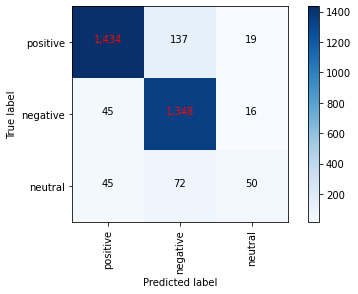

Save confusion-matrix...


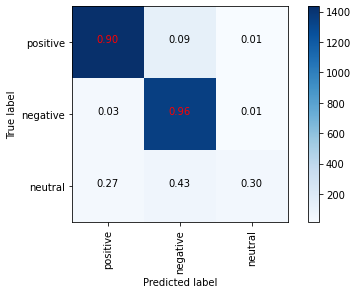

(0.8945041061276058,
 0.7983158925376875,
 0.7193316247909126,
 0.7422652103641662)

In [14]:

eval_model(model=model, data_reader=data_reader, label_col=label_col, test_df=test_df, plot_cm=True, average='macro')

In [15]:
print(model)

SimpleClassifier(
  (embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
    (token_embedder_token_characters): TokenCharactersEncoder(
      (_embedding): TimeDistributed(
        (_module): Embedding()
      )
      (_encoder): TimeDistributed(
        (_module): CnnEncoder(
          (_activation): ReLU()
          (conv_layer_0): Conv1d(34, 34, kernel_size=(3,), stride=(1,))
        )
      )
    )
  )
  (encoder): LstmSeq2VecEncoder(
    (_module): LSTM(134, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  )
  (classifier): Linear(in_features=256, out_features=3, bias=True)
)


In [ ]:
serialization_dir = '/content/drive/MyDrive/Learning/20202/NLP/attention'

if os.path.exists(serialization_dir + '/vocabulary'):
    shutil.rmtree(serialization_dir + '/vocabulary')
model.vocab.save_to_files(serialization_dir + '/vocabulary')
torch.save(model.state_dict(), serialization_dir + '/best.th')

# Train Kfold

In [16]:
from sklearn.model_selection import KFold

label_col = 'topic'
train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
df = pd.concat([train_df, val_df])

neutral_df = df[df['sentiment'] == 'neutral']
other_df = df[df['topic'] == 'other']
program_df = df[df['topic'] == 'program']
df = pd.concat([df, program_df, other_df, other_df])
splits = list(KFold(n_splits=8, shuffle=True, random_state=42).split(df))

model_folds = []
for fold, (train_idx, val_idx) in enumerate(splits):
    print('-'*40 + str(fold) + '-'*40)
    train_df_ = df.iloc[train_idx.tolist()]
    val_df_ = df.iloc[val_idx.tolist()]
    model_folds.append(
        run_training_loop(
            train_df=train_df_,
            val_df=val_df_,
            label_col=label_col,
            serialization_dir='models',
            checkpoint=False,
            use_character=False,
            bidirectional=True,
            embedding_dim=100,
            hidden_size=128,
            char_embedding_dim=34,
            dropout=0.4,
            word_embedding_pretrain_file='/content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt',
            num_epochs=5,
            grad_clipping=5,
            weight_decay=0.0001,
            use_attention=True
        )
    )
    


----------------------------------------0----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 140843.69it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
  0%|          | 0/115 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
precision: 0.7328, recall: 0.7986, f1: 0.7643, accuracy: 0.7995, batch_loss: 0.4769, loss: 0.5378 ||: 100%|##########| 115/115 [00:03<00:00, 29.87it/s]
precision: 0.7563, recall: 0.9188, f1: 0.8296, accuracy: 0.8614, batch_loss: 1.0704, loss: 0.4050 ||: 100%|##########| 17/17 [00:00<00:00, 87.51it/s]
precision: 0.8341, recall: 0.8734, f1: 0.8533, accuracy: 0.8796, batch_loss: 0.2684, loss: 0.3358 ||: 100%|##########| 115/115 [00:03<00:00, 30.99it/s]
precision: 0.8770, recall: 0.8325, f1: 0.8542, accuracy: 0.8871, batch_loss: 0.5420, loss: 0.3199 ||: 100%|##########| 17/17 [00:00<00:00, 80.02it/s]
precision

----------------------------------------1----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 146303.75it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7228, recall: 0.7870, f1: 0.7535, accuracy: 0.7926, batch_loss: 0.3245, loss: 0.5431 ||: 100%|##########| 115/115 [00:03<00:00, 29.70it/s]
precision: 0.7955, recall: 0.8550, f1: 0.8241, accuracy: 0.8466, batch_loss: 1.3358, loss: 0.4242 ||: 100%|##########| 17/17 [00:00<00:00, 84.59it/s]
precision: 0.8392, recall: 0.8669, f1: 0.8528, accuracy: 0.8793, batch_loss: 0.2365, loss: 0.3347 ||: 100%|##########| 115/115 [00:03<00:00, 30.28it/s]
precision: 0.8060, recall: 0.9069, f1: 0.8534, accuracy: 0.8752, batch_loss: 0.7285, loss: 0.3465 ||: 100%|##########| 17/17 [00:00<00:00, 84.56it/s]
precision: 0.8854, recall: 0.9005, f1: 0.8929, accuracy: 0.9136, batch_loss: 0.1693, loss: 0.2452 ||: 100%|##########| 115/115 [00:03<00:00, 30.85it/s]
precision: 0.8617, recall: 0.9130, f1: 0.8866, accuracy: 0.9019, batch_loss: 0.530

----------------------------------------2----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 141855.55it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7214, recall: 0.7886, f1: 0.7535, accuracy: 0.7926, batch_loss: 0.4184, loss: 0.5430 ||: 100%|##########| 115/115 [00:03<00:00, 29.77it/s]
precision: 0.8280, recall: 0.8026, f1: 0.8151, accuracy: 0.8552, batch_loss: 0.9093, loss: 0.4113 ||: 100%|##########| 17/17 [00:00<00:00, 83.41it/s]
precision: 0.8400, recall: 0.8659, f1: 0.8528, accuracy: 0.8786, batch_loss: 0.2268, loss: 0.3367 ||: 100%|##########| 115/115 [00:03<00:00, 30.44it/s]
precision: 0.8316, recall: 0.8867, f1: 0.8583, accuracy: 0.8838, batch_loss: 0.7125, loss: 0.3374 ||: 100%|##########| 17/17 [00:00<00:00, 84.48it/s]
precision: 0.8868, recall: 0.9000, f1: 0.8933, accuracy: 0.9146, batch_loss: 0.2023, loss: 0.2456 ||: 100%|##########| 115/115 [00:03<00:00, 30.53it/s]
precision: 0.8616, recall: 0.8964, f1: 0.8787, accuracy: 0.9004, batch_loss: 0.492

----------------------------------------3----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab: 100%|##########| 16791/16791 [00:00<00:00, 89289.27it/s]

Building the vocabulary



100%|##########| 20577/20577 [00:00<00:00, 146077.18it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7065, recall: 0.8027, f1: 0.7516, accuracy: 0.7932, batch_loss: 0.4289, loss: 0.5439 ||: 100%|##########| 115/115 [00:03<00:00, 30.22it/s]
precision: 0.8255, recall: 0.8085, f1: 0.8169, accuracy: 0.8528, batch_loss: 1.1721, loss: 0.4170 ||: 100%|##########| 17/17 [00:00<00:00, 85.43it/s]
precision: 0.8289, recall: 0.8745, f1: 0.8511, accuracy: 0.8773, batch_loss: 0.3560, loss: 0.3361 ||: 100%|##########| 115/115 [00:03<00:00, 30.27it/s]
precision: 0.8511, recall: 0.8592, f1: 0.8551, accuracy: 0.8823, batch_loss: 0.7790, loss: 0.3475 ||: 100%|##########| 17/17 [00:00<00:00, 84.91it/s]
precision: 0.8813, recall: 0.8987, f1: 0.8899, accuracy: 0.9103, batch_loss: 0.2877, loss: 0.2509 ||: 100%|##########| 115/115 [00:03<00:00, 30.95it/s]
precision: 0.8507, recall: 0.9193, f1: 0.8837, accuracy: 0.9047, batch_loss: 0.48

----------------------------------------4----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 139202.64it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7138, recall: 0.8246, f1: 0.7652, accuracy: 0.8016, batch_loss: 0.4243, loss: 0.5385 ||: 100%|##########| 115/115 [00:03<00:00, 29.80it/s]
precision: 0.7645, recall: 0.8976, f1: 0.8257, accuracy: 0.8642, batch_loss: 1.2152, loss: 0.3936 ||: 100%|##########| 17/17 [00:00<00:00, 86.33it/s]
precision: 0.8353, recall: 0.8766, f1: 0.8554, accuracy: 0.8778, batch_loss: 0.2848, loss: 0.3416 ||: 100%|##########| 115/115 [00:03<00:00, 30.63it/s]
precision: 0.8576, recall: 0.8532, f1: 0.8554, accuracy: 0.8890, batch_loss: 0.7449, loss: 0.3186 ||: 100%|##########| 17/17 [00:00<00:00, 86.84it/s]
precision: 0.8742, recall: 0.8959, f1: 0.8849, accuracy: 0.9061, batch_loss: 0.2166, loss: 0.2567 ||: 100%|##########| 115/115 [00:03<00:00, 30.70it/s]
precision: 0.8318, recall: 0.9283, f1: 0.8774, accuracy: 0.9042, batch_loss: 0.740

----------------------------------------5----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


  0%|          | 0/20577 [00:00<?, ?it/s]

Building the vocabulary


100%|##########| 20577/20577 [00:00<00:00, 131819.32it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7272, recall: 0.7821, f1: 0.7537, accuracy: 0.7936, batch_loss: 0.4761, loss: 0.5469 ||: 100%|##########| 115/115 [00:03<00:00, 30.25it/s]
precision: 0.7890, recall: 0.8469, f1: 0.8169, accuracy: 0.8404, batch_loss: 1.1866, loss: 0.4632 ||: 100%|##########| 17/17 [00:00<00:00, 85.38it/s]
precision: 0.8381, recall: 0.8744, f1: 0.8559, accuracy: 0.8801, batch_loss: 0.3589, loss: 0.3334 ||: 100%|##########| 115/115 [00:03<00:00, 30.62it/s]
precision: 0.8245, recall: 0.8469, f1: 0.8356, accuracy: 0.8647, batch_loss: 0.9478, loss: 0.4058 ||: 100%|##########| 17/17 [00:00<00:00, 80.71it/s]
precision: 0.8852, recall: 0.9051, f1: 0.8950, accuracy: 0.9128, batch_loss: 0.2303, loss: 0.2488 ||: 100%|##########| 115/115 [00:03<00:00, 30.53it/s]
precision: 0.8556, recall: 0.8596, f1: 0.8576, accuracy: 0.8842, batch_loss: 0.542

----------------------------------------6----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab: 100%|##########| 16791/16791 [00:00<00:00, 87781.81it/s]

Building the vocabulary



100%|##########| 20577/20577 [00:00<00:00, 140999.23it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7087, recall: 0.8108, f1: 0.7563, accuracy: 0.7967, batch_loss: 0.4398, loss: 0.5430 ||: 100%|##########| 115/115 [00:03<00:00, 30.09it/s]
precision: 0.7789, recall: 0.8526, f1: 0.8141, accuracy: 0.8394, batch_loss: 1.3207, loss: 0.4701 ||: 100%|##########| 17/17 [00:00<00:00, 86.90it/s]
precision: 0.8352, recall: 0.8711, f1: 0.8528, accuracy: 0.8800, batch_loss: 0.4369, loss: 0.3324 ||: 100%|##########| 115/115 [00:03<00:00, 30.96it/s]
precision: 0.8729, recall: 0.8365, f1: 0.8543, accuracy: 0.8733, batch_loss: 0.8857, loss: 0.3978 ||: 100%|##########| 17/17 [00:00<00:00, 82.64it/s]
precision: 0.8830, recall: 0.8998, f1: 0.8913, accuracy: 0.9105, batch_loss: 0.2061, loss: 0.2506 ||: 100%|##########| 115/115 [00:03<00:00, 30.29it/s]
precision: 0.8172, recall: 0.9311, f1: 0.8704, accuracy: 0.8895, batch_loss: 0.74

----------------------------------------7----------------------------------------
num_epochs 5
word_embedding_pretrain_file /content/drive/MyDrive/Learning/20202/NLP/w2v/pretrained/viki_adapt/viki_adapt_w2v.txt
dropout 0.4
grad_clipping 5
weight_decay 0.0001
Reading data


building vocab: 100%|##########| 16791/16791 [00:00<00:00, 94821.59it/s]

Building the vocabulary



100%|##########| 20577/20577 [00:00<00:00, 143982.84it/s]
You provided a validation dataset but patience was set to None, meaning that early stopping is disabled
precision: 0.7151, recall: 0.7983, f1: 0.7544, accuracy: 0.7943, batch_loss: 0.3764, loss: 0.5472 ||: 100%|##########| 115/115 [00:03<00:00, 30.39it/s]
precision: 0.7796, recall: 0.8093, f1: 0.7941, accuracy: 0.8379, batch_loss: 1.0074, loss: 0.4366 ||: 100%|##########| 17/17 [00:00<00:00, 86.19it/s]
precision: 0.8338, recall: 0.8733, f1: 0.8531, accuracy: 0.8786, batch_loss: 0.2593, loss: 0.3392 ||: 100%|##########| 115/115 [00:03<00:00, 30.94it/s]
precision: 0.8336, recall: 0.8557, f1: 0.8445, accuracy: 0.8661, batch_loss: 0.9133, loss: 0.3658 ||: 100%|##########| 17/17 [00:00<00:00, 84.48it/s]
precision: 0.8832, recall: 0.8966, f1: 0.8898, accuracy: 0.9104, batch_loss: 0.2309, loss: 0.2516 ||: 100%|##########| 115/115 [00:03<00:00, 31.20it/s]
precision: 0.8389, recall: 0.8806, f1: 0.8592, accuracy: 0.8832, batch_loss: 0.58

## Evaluate KFold

In [17]:
import numpy as np
def predict_kfold(model_folds, text: str):
    # print(text)
    tokens = [Token(token) for token in text.split(' ')]
    token_indexers = model_folds[0][1].token_indexers
    max_tokens = model_folds[0][1].max_tokens
    models = [x[0] for x in model_folds]
    vocab = model_folds[0][0].vocab

    if len(tokens) > max_tokens:
        tokens = tokens[:max_tokens]
    text_field = TextField(tokens, token_indexers)
    instance = Instance({
        "tokens": text_field
    })
    outputs = [model.forward_on_instance(instance) for model in models]
    y_predictions = [np.argmax(output['probs'], axis=-1) for output in outputs]
    y_probs = [np.max(output['probs'], axis=-1) for output in outputs]
    predictions = [vocab.get_token_from_index(y_prediction, namespace='labels') for y_prediction in y_predictions]
    predictioin_final = max(predictions, key = predictions.count)
    return predictioin_final

In [18]:
predict_kfold(model_folds, "nội dung môn học phù hợp, bắt đúng xu thế")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'program'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.8720783322804802
Precision: 0.7840098720443242
Recall   : 0.7744028025512684
F1-Score : 0.7777801291968349
              precision    recall  f1-score   support

    lecturer       0.94      0.92      0.93      2290
     program       0.70      0.79      0.74       572
       other       0.54      0.53      0.53       159
    facility       0.96      0.86      0.91       145

    accuracy                           0.87      3166
   macro avg       0.78      0.77      0.78      3166
weighted avg       0.88      0.87      0.87      3166

Save confusion-matrix...


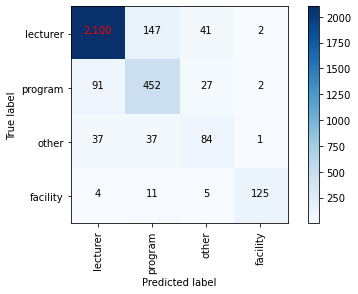

Save confusion-matrix...


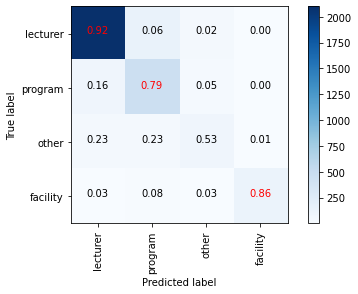

In [19]:
vocab = model_folds[0][0].vocab

test_df = pd.read_csv(test_path)
texts = test_df['text'].tolist()
label_true = test_df[label_col].tolist()
label_pred = [predict_kfold(model_folds, text) for text in texts]
y_true = [vocab.get_token_index(label, namespace='labels') for label in label_true]
y_pred = [vocab.get_token_index(label, namespace='labels') for label in label_pred]

# get metric scores
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

labels = list(vocab.get_token_to_index_vocabulary('labels').keys())
report = classification_report(label_true, label_pred, labels=labels)
print(f'Evaluate ')
print('Accuracy :', acc)
print('Precision:', precision)
print('Recall   :', recall)
print('F1-Score :', f1)
print(report)

cm = confusion_matrix(label_true, label_pred, labels=labels)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix ({label_col})', normalize=False)
plot_confusion_matrix(cm, target_names=labels, title=f'Confusion Matrix Normalize ({label_col})', normalize=True)

In [20]:
result_models = []
for model, data_reader in model_folds:
    print('-'*80)
    result = eval_model(model, data_reader, test_df, label_col=label_col)
    result_models.append(result)

--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.8626026531901453
Precision: 0.7596244963991938
Recall   : 0.7647704180291908
F1-Score : 0.7600308766569503
Detail:
              precision    recall  f1-score   support

    lecturer       0.94      0.91      0.93      2290
     program       0.70      0.77      0.73       572
       other       0.45      0.53      0.49       159
    facility       0.95      0.85      0.90       145

    accuracy                           0.86      3166
   macro avg       0.76      0.76      0.76      3166
weighted avg       0.87      0.86      0.87      3166

--------------------------------------------------------------------------------
Evaluate 
Accuracy : 0.8676563487049905
Precision: 0.7727421751649087
Recall   : 0.7852359067897619
F1-Score : 0.7765519547481977
Detail:
              precision    recall  f1-score   support

    lecturer       0.95      0.90      0.92      2290
     program       0.69      0.81      0.75       572
       other       0.48      0.55      0.51  

In [21]:
f1s = [x[-1] for x in result_models]
best_model_index = np.argmax(f1s)
print(result_models[best_model_index])
# print(model_folds[best_model_index][0])
serialization_dir = '/content/drive/MyDrive/Learning/20202/NLP/best_model_kfold_1up_char'
dataset_reader =  model_folds[best_model_index][1]
best_model = model_folds[best_model_index][0]
if os.path.exists(serialization_dir + '/vocabulary'):
    shutil.rmtree(serialization_dir + '/vocabulary')
best_model.vocab.save_to_files(serialization_dir + '/vocabulary')
torch.save(best_model.state_dict(), serialization_dir + '/best.th')

(0.8676563487049905, 0.7727421751649087, 0.7852359067897619, 0.7765519547481977)


In [22]:
print(best_model)

AttentionClassifier(
  (embedder): BasicTextFieldEmbedder(
    (token_embedder_tokens): Embedding()
  )
  (encoder): LstmSeq2SeqEncoder(
    (_module): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  )
  (attention_layer): AdditiveAttention()
  (relu): ReLU()
  (drop): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=512, out_features=4, bias=True)
)


## eval best model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Evaluate 
Accuracy : 0.8676563487049905
Precision: 0.7727421751649087
Recall   : 0.7852359067897619
F1-Score : 0.7765519547481977
Detail:
              precision    recall  f1-score   support

    lecturer       0.95      0.90      0.92      2290
     program       0.69      0.81      0.75       572
       other       0.48      0.55      0.51       159
    facility       0.97      0.88      0.92       145

    accuracy                           0.87      3166
   macro avg       0.77      0.79      0.78      3166
weighted avg       0.88      0.87      0.87      3166

Save confusion-matrix...


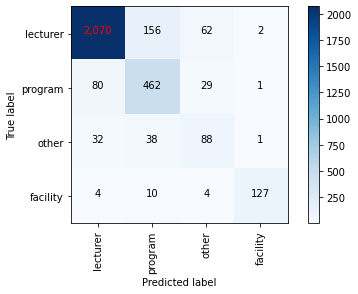

Save confusion-matrix...


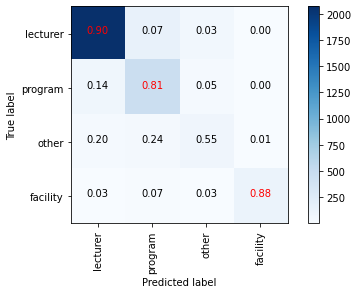

(0.8676563487049905,
 0.7727421751649087,
 0.7852359067897619,
 0.7765519547481977)

In [23]:
eval_model(best_model, dataset_reader, test_df, plot_cm=True, label_col=label_col)

In [24]:
test_df = predict_on_df(model=best_model, data_reader=dataset_reader, data_df=test_df,label_col='sentiment')
test_df_false = test_df[test_df['sentiment'] != test_df['sentiment_pred']]
test_df_true = test_df[test_df['sentiment'] == test_df['sentiment_pred']]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [25]:
test_df_false.to_csv('/content/drive/MyDrive/Learning/20202/NLP/false_sent_pred.csv', index=False)
test_df_true.to_csv('/content/drive/MyDrive/Learning/20202/NLP/true_sent_pred.csv', index=False)